In [1]:
# @version : 05/2023
# @author : grafika_jati
# LiDAR cover contaminant classification using 2D CNN. Input is 2D spherical image

# Split train and test from dataset taken by # B. Schlager, T. Goelles, S. Muckenhuber and D. Watzenig, "Contaminations on Lidar Sensor Covers: Performance Degradation Including Fault Detection and Modeling as Potential Applications," in IEEE Open Journal of Intelligent Transportation Systems, vol. 3, pp. 738-747, 2022, doi: 10.1109/OJITS.2022.3214094.

# Train : exp 1,2,3,4
# Test : exp 5



import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
from torch.optim import Adam
from sklearn.model_selection import KFold
import math
import time as ti
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools

from sklearn.metrics import classification_report


if torch.cuda.is_available():
  dev = "cuda:3"
  print("yey")
device = torch.device(dev)


yey


In [2]:
# Define a function to plot confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    # plt.savefig('2D_spherical_proj_class_norm_per_exp_train_test_IRA_30x70_Conf/all-exp-'+'2D_spherical_proj_class_norm_per_exp_train_test-IRA-30x70'+'.png')

    plt.savefig('2D_spherical_proj_class_norm_per_exp_train_test_IRA_9x16_Conf/all-exp-'+'2D_spherical_proj_class_norm_per_exp_train_test-IRA-9x16'+'.png')

    plt.clf()

In [3]:
# Define relevant variables for the ML task
batch_size = 32
num_classes = 6
learning_rate = 0.01 #0.001 #0.01
num_epochs = 150 #150 # 100 #50 #10 #30


# BEST PARAM
# batch_size = 32
# num_classes = 10
# learning_rate = 0.001
# num_epochs = 100

In [5]:
#Load dataset
# df = pd.read_json('../get_2D_spherical_Norm_per_exp_train_test/lidar_norm_train_test_2d_spherical_10class_DRA_30x70.json')
# df = pd.read_json('../get_2D_spherical_Norm_per_exp_train_test/lidar_norm_train_test_2d_spherical_10class_DRA_9x16.json')

df = pd.read_json('../get_2D_spherical_Norm_per_exp_train_test/lidar_norm_train_test_2d_spherical_10class_norm_DRA_9x16.json')


df_add = df

#get data class=ref without cover
df_no_cover =df_add[df_add['class'] == 'no_cover']
df_ref_train = df_no_cover.sample(frac=0.80,random_state=1)
df_ref_test = df_no_cover.drop(df_ref_train.index)


#get data class=ref with cover
df_cover =df_add[df_add['class'] == 'cover']
df_ref_wh_train = df_cover.sample(frac=0.80,random_state=1)
df_ref_wh_test = df_cover.drop(df_ref_wh_train.index)

#get data class oil, foam, dirt, water from exp 1,2,3,4
#get training data
df_water_all=df_add[df_add['class'] == 'water']
df_water_1=df_water_all[df_water_all['exp'].isin([1])] 
df_water_2=df_water_all[df_water_all['exp'].isin([2])] 
df_water_3=df_water_all[df_water_all['exp'].isin([3])] 
df_water_4=df_water_all[df_water_all['exp'].isin([4])] 
df_water_5=df_water_all[df_water_all['exp'].isin([5])] 


df_oil_all=df_add[df_add['class'] == 'oil']
df_oil_1=df_oil_all[df_oil_all['exp'].isin([1])] 
df_oil_2=df_oil_all[df_oil_all['exp'].isin([2])] 
df_oil_3=df_oil_all[df_oil_all['exp'].isin([3])] 
df_oil_4=df_oil_all[df_oil_all['exp'].isin([4])] 
df_oil_5=df_oil_all[df_oil_all['exp'].isin([5])] 

df_foam_all=df_add[df_add['class'] == 'foam']
df_foam_1=df_foam_all[df_foam_all['exp'].isin([1])] 
df_foam_2=df_foam_all[df_foam_all['exp'].isin([2])] 
df_foam_3=df_foam_all[df_foam_all['exp'].isin([3])] 
df_foam_4=df_foam_all[df_foam_all['exp'].isin([4])] 
df_foam_5=df_foam_all[df_foam_all['exp'].isin([5])] 

df_dirt_all=df_add[df_add['class'] == 'dirt']
df_dirt_1=df_dirt_all[df_dirt_all['exp'].isin([1])] 
df_dirt_2=df_dirt_all[df_dirt_all['exp'].isin([2])] 
df_dirt_3=df_dirt_all[df_dirt_all['exp'].isin([3])] 
df_dirt_4=df_dirt_all[df_dirt_all['exp'].isin([4])] 
df_dirt_5=df_dirt_all[df_dirt_all['exp'].isin([5])] 


In [6]:
def flatChannels(x):
    size = x.size()
    # print("flatChannels")
    # print(size)
    return x.view(size[0],size[1],size[2]*size[3])

def globalAvgPool2D(x):        
    return flatChannels(x).mean(dim=-1)

def globalMaxPool2D(x):
    return flatChannels(x).max(dim=-1)
    
class Unit(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(Unit,self).__init__()
        

        self.conv = nn.Conv2d(in_channels=in_channels,kernel_size=3,out_channels=out_channels,stride=1,padding=1) # 
        self.bn = nn.BatchNorm2d(num_features=out_channels)
        self.relu = nn.ReLU()

    def forward(self,input):
        output = self.conv(input)
        # output = self.bn(output)
        output = self.relu(output)

        return output

class Net(nn.Module):
    def __init__(self,num_classes):
        super(Net,self).__init__()

        #Create 14 layers of the unit with max pooling in between
        self.unit0 = Unit(in_channels=3,out_channels=16)
        self.unit15 = Unit(in_channels=16,out_channels=32)
        self.unit16 = Unit(in_channels=32,out_channels=64)
      
        self.avgpool = nn.AvgPool2d(kernel_size=4)
        
        #Add all the units into the Sequential layer in exact order
        
        self.net = nn.Sequential(self.unit0, self.unit15, self.unit16) #BEST
        self.fc = nn.Linear(in_features=64,out_features=num_classes) #BEST
      

    def forward(self, input):
        output = self.net(input)
        output = globalAvgPool2D(output) 
        output = self.fc(output)
        return output


In [7]:
def train_net(num_epochs): #Training your network
    losses = []
    for epoch in range(num_epochs): # loop over the dataset multiple times
   
        train_acc = 0.0
        train_loss = 0.0
     
        for i, data in enumerate(list_train_tensor, 0):
     
            #get the input; data is a list of [input, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device=device), labels.to(device=device)
            
            # zero the parameter gradients
            optimizer.zero_grad()
    
           # forward pass 
            outputs = net(inputs)
    
            loss = criterion(outputs, labels)

            # backward and optimize
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, prediction = torch.max(outputs.data, 1)
      
            train_acc += torch.sum(prediction == labels.data)

        #Compute the average acc and loss over all 50000 training images
        train_acc = train_acc / df_train_X_tensor.size()[0]
        train_loss = train_loss / df_train_X_tensor.size()[0]

         # Print the metrics
        print("Epoch {}, Train Accuracy: {} , Train Loss: {}".format(epoch, train_acc, train_loss))
            # print statistics
        losses.append(loss.data.cpu())
      
    plt.plot(losses, label ='Training loss')
    plt.show()
    print('Finished Training')


In [8]:
#Split dataset for training and testing
frame_A_train = [df_ref_train, df_ref_wh_train, df_water_1, df_water_2, df_water_3, df_water_4, df_oil_1, df_oil_2, df_oil_3, df_oil_4, df_foam_1, df_foam_2, df_foam_3, df_foam_4,df_dirt_1, df_dirt_2, df_dirt_3, df_dirt_4]

df_A_train = pd.DataFrame()

for df in frame_A_train:
    df_A_train = df_A_train.append(df)

frame_A_test = [df_ref_test, df_ref_wh_test, df_water_5, df_oil_5, df_foam_5, df_dirt_5]

df_A_test = pd.DataFrame()

for df in frame_A_test:
    df_A_test = df_A_test.append(df)

/tmp/ipykernel_2742189/851170086.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_A_train = df_A_train.append(df)
/tmp/ipykernel_2742189/851170086.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_A_train = df_A_train.append(df)
/tmp/ipykernel_2742189/851170086.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_A_train = df_A_train.append(df)
/tmp/ipykernel_2742189/851170086.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_A_train = df_A_train.append(df)
/tmp/ipykernel_2742189/851170086.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

In [9]:
# Normalize data train and data test

df_A_train_clean =  df_A_train.drop('exp', axis=1)
df_A_test_clean =  df_A_test.drop('exp', axis=1)

df_A_train_clean = df_A_train_clean.sample(frac = 1,random_state=1)
df_A_test_clean = df_A_test_clean.sample(frac = 1,random_state=1)

df_A_train_X = df_A_train_clean.drop('class', axis=1)
df_A_train_Y = df_A_train_clean['class']

df_A_test_X = df_A_test_clean.drop('class', axis=1)
df_A_test_Y = df_A_test_clean['class']

In [10]:
df_train_X = df_A_train_X
df_train_Y = df_A_train_Y

df_test_X = df_A_test_X
df_test_Y = df_A_test_Y

Training for FOLD: 
Epoch 0, Train Accuracy: 0.28287172317504883 , Train Loss: 0.05101737138820483
Epoch 1, Train Accuracy: 0.6706103682518005 , Train Loss: 0.027142645202679287
Epoch 2, Train Accuracy: 0.8552029728889465 , Train Loss: 0.01215182938749478
Epoch 3, Train Accuracy: 0.889620840549469 , Train Loss: 0.00888135351649325
Epoch 4, Train Accuracy: 0.9244419932365417 , Train Loss: 0.006374086649013113
Epoch 5, Train Accuracy: 0.9481042623519897 , Train Loss: 0.0047927148419533265
Epoch 6, Train Accuracy: 0.9611454010009766 , Train Loss: 0.003753834417323715
Epoch 7, Train Accuracy: 0.9693465828895569 , Train Loss: 0.0029311307447252013
Epoch 8, Train Accuracy: 0.9725732207298279 , Train Loss: 0.00275609693722862
Epoch 9, Train Accuracy: 0.9702876806259155 , Train Loss: 0.003024294905556838
Epoch 10, Train Accuracy: 0.9739176630973816 , Train Loss: 0.0027284467254201127
Epoch 11, Train Accuracy: 0.976606547832489 , Train Loss: 0.0024338722610648326
Epoch 12, Train Accuracy: 0.978

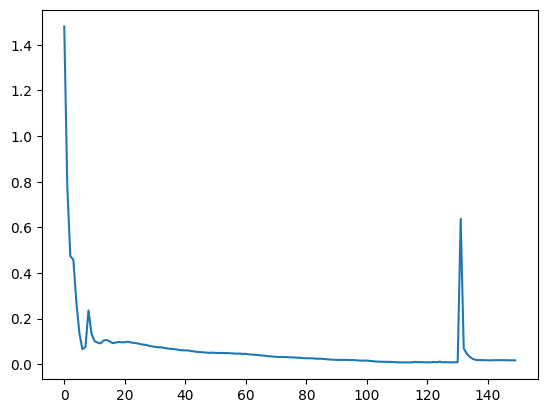

Finished Training
Accuracy of the network on the 1792 test images: 97 %


<Figure size 640x480 with 0 Axes>

In [11]:
encoded_train_Y = df_train_Y.map({'no_cover':0, 'cover':1, 'dirt':2, 'foam':3, 'oil':4, 'water':5})
encoded_test_Y = df_test_Y.map({'no_cover':0, 'cover':1, 'dirt':2, 'foam':3, 'oil':4, 'water':5})

Y_train_dummy=encoded_train_Y
Y_test_dummy=encoded_test_Y


#convert data train to tensor
list_df_train_X = []
for item in range(len(df_train_X['data'])):
    list_df_train_X.append(df_train_X['data'].iloc[item])

# df_A_train_X_tensor = torch.FloatTensor(list_df_A_train_X,device=device)
df_train_X_tensor = torch.FloatTensor(list_df_train_X)

#convert data test to tensor
list_df_test_X = []
for item in range(len(df_test_X['data'])):
    list_df_test_X.append(df_test_X['data'].iloc[item])

# df_A_test_X_tensor = torch.FloatTensor(list_df_A_test_X,device=device)
df_test_X_tensor = torch.FloatTensor(list_df_test_X)


# convert label to tensor
encoded_train_Y_tensor = torch.from_numpy(Y_train_dummy.to_numpy())
encoded_test_Y_tensor = torch.from_numpy(Y_test_dummy.to_numpy())

# # get batch for each FOLD TRAINING    
num_batches = math.ceil(df_train_X_tensor.size()[0]/batch_size)
train_X_raw = [df_train_X_tensor[batch_size*y:batch_size*(y+1),:,:] for y in range(num_batches)]
# print(train_X_raw[0].size())

num_batches = math.ceil(encoded_train_Y_tensor.size()[0]/batch_size)
train_Y_raw = [encoded_train_Y_tensor[batch_size*y:batch_size*(y+1)] for y in range(num_batches)]
# print(train_Y_raw[0].size())

List_train_row = len(train_X_raw)
List_train_columns = 2
list_train_tensor = [[ 0 for x in range(List_train_columns)] for i in range (List_train_row)]

for i in range(List_train_row):
    for j in range(List_train_columns):
        list_train_tensor[i][0]=train_X_raw[i]
        list_train_tensor[i][1]=train_Y_raw[i]


# # get batch for each FOLD TESTING
num_batches = math.ceil(df_test_X_tensor.size()[0]/batch_size)
test_X_raw = [df_test_X_tensor[batch_size*y:batch_size*(y+1),:,:] for y in range(num_batches)]
# print(test_X_raw[0].size())

num_batches = math.ceil(encoded_test_Y_tensor.size()[0]/batch_size)
test_Y_raw = [encoded_test_Y_tensor[batch_size*y:batch_size*(y+1)] for y in range(num_batches)]
# print(test_Y_raw[0].size())

List_test_row = len(test_X_raw)
List_test_columns = 2
list_test_tensor = [[ 0 for x in range(List_test_columns)] for i in range (List_test_row)]

for i in range(List_test_row):
    for j in range(List_test_columns):
        list_test_tensor[i][0]=test_X_raw[i]
        list_test_tensor[i][1]=test_Y_raw[i]

print("Training for FOLD: ")

#initialize the network
net = Net(num_classes).cuda(device=device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
# optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.1)

criterion = criterion.cuda(device=device)

t = ti.time()

train_net(num_epochs)

elapsed_training = ti.time() - t
training_time = elapsed_training

#save model
torch.save(net, "model_2D_spherical_proj_class_norm_per_exp_train_test_IRA_9x16.pt")

class_name = ['clean', 'cover','dirt', 'foam', 'oil', 'water']

correct = 0
total = 0
list_test_labels = []
list_test_predicted = []

timings_inference = []

with torch.no_grad():
    for i, data in enumerate(list_test_tensor, 0):
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        t = ti.time()
        outputs = net(images)
        elapsed_training = ti.time() - t
        timings_inference.append(elapsed_training)


        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        labels_cpu = labels.tolist()
        predicted_cpu = predicted.tolist() 
        for jj in range(len(labels_cpu)):

            list_test_labels.append(labels_cpu[jj])
            list_test_predicted.append(predicted_cpu[jj])

sum_syn = np.sum(timings_inference) # inference time per epoch
mean_syn_per_instance = np.sum(timings_inference)/len(list_test_predicted) # inference time per epoch


correct_CPU = 0
total_CPU = 0
list_test_labels_CPU = []
list_test_predicted_CPU = []

timings_inference_CPU = []

net_CPU = net.cpu()

with torch.no_grad():
    for i, data in enumerate(list_test_tensor, 0):
        images, labels = data
        
        t = ti.time()
        outputs = net_CPU(images)
        elapsed_training = ti.time() - t

        
        timings_inference_CPU.append(elapsed_training)
        
        _, predicted = torch.max(outputs.data, 1)
        total_CPU += labels.size(0)
        correct_CPU += (predicted == labels).sum().item()

        labels_cpu = labels.tolist()
        predicted_cpu = predicted.tolist() 
        for jj in range(len(labels_cpu)):

            list_test_labels_CPU.append(labels_cpu[jj])
            list_test_predicted_CPU.append(predicted_cpu[jj])

sum_syn_CPU = np.sum(timings_inference_CPU) # inference time per epoch
mean_syn_per_instance_CPU = np.sum(timings_inference_CPU)/len(list_test_predicted_CPU) # inference time per epoch


with open("output_2D_spherical_proj_class_norm_per_exp_train_test_IRA_9x16.txt", "a") as f:

    print("CNN 2D - fold: ", file=f)
    print(classification_report(list_test_labels,list_test_predicted,target_names=class_name), file=f)
    print("Training time per Fold:", training_time, file=f)
    print("Inference time per Fold:", sum_syn, file=f)

    print("Inference instance:", len(list_test_predicted), file=f)
    print("Inference time per instance:", mean_syn_per_instance, file=f)

    print("=====CPU=========", file=f)

    print(classification_report(list_test_labels_CPU,list_test_predicted_CPU,target_names=class_name), file=f)
    print("Inference time per Fold CPU:", sum_syn_CPU, file=f)
    print("Inference instance CPU:", len(list_test_predicted_CPU), file=f)
    print("Inference time per instance CPU:", mean_syn_per_instance_CPU, file=f)
    
    print("=================", file=f)   
    
print('Accuracy of the network on the %d test images: %d %%' % (num_batches*batch_size,
    100 * correct / total))
confusion_mtx = confusion_matrix(list_test_labels, list_test_predicted) 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx,class_name) 
